In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from pprint import pprint
import tqdm

from scipy.stats import chi2_contingency
from sklearn.metrics.pairwise import cosine_distances
import re

In [2]:
from rdkit import Chem

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
DEVICE = 'cuda:0'

## Read data

In [1383]:
dframe = pd.read_csv("data/smiles_data.csv").drop_duplicates(['smiles'])

In [1384]:
dframe

,Unnamed: 0,smiles,fname,set
0,0,c1ccccc1N(CNC2=O)C23CCN(CC3)C(=O)OCc4cccc(c4)O...,mu_human_IC50_binding_all_inactives_450_struct...,train
1,1,c1cccc(c12)n(c(=O)[nH]2)C3CCN(CC3)C(=O)OCc(c4)...,mu_human_IC50_binding_all_inactives_450_struct...,train
3,3,COc1cc(N)c(Cl)cc1C(=O)NCC[N@H+](C)C[C@H](CCCC2...,mu_human_IC50_binding_all_inactives_450_struct...,val
5,5,Oc(c1)cccc1[C@@]2(O)[C@@H](CCCC2)C[N@H+](C[C@@...,mu_human_IC50_binding_all_inactives_450_struct...,train
6,6,O[C@@H]1CC[N@@H+](C1)C[C@@H](c2ccccc2)n3cccc(c...,mu_human_IC50_binding_all_inactives_450_struct...,train
...,...,...,...,...
70782,70782,CCO[C@@]1([C@@]234)[C@H](N(C)CC3)Cc5c4c(c(O)cc...,mu_rat_Ki_all_inactives_1006_structures.sdf:209,train
70807,70807,ICCOCC[C@](COC)(C[C@H]1C(=O)OC)C(=O)[C@@H]([C@...,mu_rat_Ki_all_inactives_1006_structures.sdf:42,train
70970,70970,ICCCCC[C@](COC)(C[C@H]1C(=O)OC)C(=O)[C@@H]([C@...,mu_rat_Ki_all_inactives_1006_structures.sdf:105,train
71006,71006,CCN(CC)C(=O)c1ccc(cc1)N(c2cccc(c2)OC)[C@@H](C[...,mu_rat_Ki_all_inactives_1006_structures.sdf:97,train


### Chemformer

In [7]:
from molbart.decoder import DecodeSampler
from molbart.tokeniser import MolEncTokeniser
from molbart.models.pre_train import BARTModel

import molbart.util as util
import torch
from molbart.data.datamodules import MoleculeDataModule

from rdkit import Chem

In [8]:
class Config:
    model_path="./weights/mask/version_16/checkpoints/epoch=479-step=54719.ckpt"

tokeniser = util.load_tokeniser("/home/wwydmanski/Chemformer/bart_vocab.txt", util.DEFAULT_CHEM_TOKEN_START)
sampler = DecodeSampler(tokeniser, util.DEFAULT_MAX_SEQ_LEN)
chemformer = util.load_bart(Config, sampler)
chemformer = chemformer.cuda()

chemformer.freeze()

In [939]:
def encode(smiles):
    encoded = []
    # I don't get attention masks, so we will just need to avoid them
    for smile in smiles:
        token_output = tokeniser.tokenise([smile], pad=True)
        enc_token_ids = tokeniser.convert_tokens_to_ids(token_output['original_tokens'])

        encoder_input = torch.tensor(enc_token_ids).cuda().T
        encoder_pad_mask = torch.tensor(token_output["original_pad_masks"]).cuda()

        encoder_embs = chemformer._construct_input(encoder_input)
        res = chemformer.encoder(encoder_embs, src_key_padding_mask=encoder_pad_mask)
        encoded.append(res.cpu().detach().numpy()[-1, 0])
    return np.stack(encoded, 0)

In [941]:
encode(['c1ccccc1N(CNC2=O)C23CCN(CC3)C(=O)OCc4cccc(c4)Oc5ccccc5'])[0][:10]

array([ 0.02064733, -0.0102493 ,  0.09934792,  0.03197001,  0.03521706,
       -0.059735  ,  0.01213152, -0.00939642, -0.06601654, -0.03636185],
      dtype=float32)

### Optimizing network

In [925]:
class BindingPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.Dropout(),
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.Dropout(),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, 32),
            nn.ReLU(),
            
            nn.Linear(32, 2),
            nn.Sigmoid()
        ).cuda()
    
    def parameters(self):
        return self.network.parameters()
    
    def forward(self, X):
        return self.network(X)
    
    def to(self, *args, **kwargs):
        self.network.to(*args, **kwargs)
        super().to(*args, **kwargs)
    
    def predict(self, X):
        res = self.network(torch.Tensor(X).cuda())
        res = res.round().to(torch.int)
        return res.cpu().detach().numpy()
    
    def proba(self, X):
        res = self.network(torch.Tensor(X).cuda())
        return res.cpu().detach().numpy()
    
model = torch.load("weights/mu_activity")

In [926]:
model.eval()
model.proba([encode(["c1ccccc1N(CNC2=O)C23CCN(CC3)C(=O)OCc4cccc(c4)Oc5ccccc5"])[0]])[0]

array([0.9999536 , 0.29874465], dtype=float32)

## Molecule optimization

In [1577]:
class MolecularOptimizer:
    WEIGHTS = [1, 10]
    
    def __init__(self, tokeniser, chemformer, score_fn, smiles):
        self.score_fn = score_fn
        self.chemformer = chemformer
        self.tokeniser = tokeniser
        self.smiles = smiles
    
    def _get_last_layer(self, smiles):
        token_output = self.tokeniser.tokenise(smiles, pad=True)
        enc_token_ids = self.tokeniser.convert_tokens_to_ids(token_output['original_tokens'])

        enc_input = torch.tensor(enc_token_ids).cuda().T
        enc_mask = torch.tensor(token_output["original_pad_masks"]).cuda().T

        encode_input = {
            "encoder_input": enc_input,
            "encoder_pad_mask": enc_mask
        }

        # Output of the last layer will be passed subsequent decoder layers
        memory = chemformer.encode(encode_input)
        mem_mask = enc_mask.clone()
        del token_output
        del encode_input
        return memory, mem_mask, enc_token_ids, enc_input

    def _prepare_for_decoding(self, enc_input, mem_mask, memory):
        # Mask the token that we want to optimize
        enc_input[mask_idx] = self.tokeniser.vocab['<MASK>']
        pad_mask = torch.ones(enc_input.shape).to(torch.int)

        # Convert decoder input to encodable format
        decoder_input = enc_input
        decoder_pad_mask = pad_mask.transpose(0, 1)
        memory_input = memory
        memory_pad_mask = mem_mask.transpose(0, 1)

        decoder_embs = self.chemformer._construct_input(decoder_input)
        
        del decoder_input
        return decoder_embs, memory_input, decoder_pad_mask, memory_pad_mask

    def get_transformer_ll(self, smiles, mask_idx):
        """ Get log-likelihood of the tokens according to the transformers model """
        memory, mem_mask, enc_token_ids, enc_input = self._get_last_layer(smiles)
        decoder_embs, memory_input, decoder_pad_mask, memory_pad_mask = self._prepare_for_decoding(enc_input, mem_mask, memory)

        # Get token log likelihood
        model_output = self.chemformer.decoder(
            decoder_embs.to(DEVICE), 
            memory_input.to(DEVICE),
            tgt_key_padding_mask=decoder_pad_mask.to(DEVICE),
            memory_key_padding_mask=memory_pad_mask.to(DEVICE)
        )
        token_output = self.chemformer.token_fc(model_output)
        token_probs = self.chemformer.log_softmax(token_output)
        token_probs = token_probs[mask_idx]
        token_probs = token_probs[0]
        
        del model_output
        del memory_pad_mask
        del decoder_pad_mask
        del decoder_embs
        del memory_input
        return token_probs.cpu().detach()

    def _to_smiles(self, smiles, mask_idx, probs=None):
        idx_arr = np.arange(len(probs))

        token_output = self.tokeniser.tokenise(smiles)
        enc_token_ids = self.tokeniser.convert_tokens_to_ids(token_output['original_tokens'])
        smiles_arr = [enc_token_ids]*len(idx_arr)
        
        smiles_arr = np.array(smiles_arr)[:, 0]

        smiles_arr[:, mask_idx] = idx_arr
        new_smiles = self.tokeniser.convert_ids_to_tokens(smiles_arr)
        new_smiles = self.tokeniser.detokenise(new_smiles)
        return new_smiles
    
    def calculate_step(self, smiles, mask_idx):
        token_probs = self.get_transformer_ll(smiles, mask_idx)
        
        candidate_smiles = self._to_smiles(smiles, mask_idx, probs=token_probs)
        score = self.score_fn(candidate_smiles)

        probs = token_probs*self.WEIGHTS[0] + score*self.WEIGHTS[1]
        
        probs /= self.WEIGHTS[0]+self.WEIGHTS[1]

        smiles = self._to_smiles(smiles, mask_idx, probs)
        smiles = np.array(smiles)[tokeniser.chem_token_idxs]
        probs = probs[tokeniser.chem_token_idxs]  
        return smiles, probs, score

In [1542]:
class SamplerModes:
    GREEDY = 1
    BEAM = 2

class Sampler:
    def __init__(self, optimizer, mode=SamplerModes.GREEDY, max_steps=100):
        self.mode = mode
        self.next_iter = [optimizer.smiles]
        self.original_len = len(tokeniser.tokenise(optimizer.smiles)['original_tokens'])
        self.mask_idx = 1
        self.optimizer = optimizer
        self.queue = []
        self.excluded = []
        self.max_steps = max_steps
        self.loss = []
        self.step = 0
        self.current_best = (None, -np.inf)
        
    def _sample_greedy(self):
        smiles, scores, losses = self.optimizer.calculate_step(self.next_iter, self.mask_idx)
        joined = [(i, j.item(), k.item(), self.mask_idx) for i, j, k in zip(smiles, scores, losses) if i not in self.excluded]
        joined = sorted(joined, key=lambda x: x[1], reverse=True)
        self.queue = [*joined, *self.queue]
        
        next_iter = None
        for candidate, score, loss, mask_idx in self.queue:
            if Chem.MolFromSmiles(candidate) is not None:
                if len(tokeniser.tokenise(candidate)['original_tokens']) == self.original_len:
                    self.next_iter = [candidate]
                    self.loss.append(loss)
                    self.mask_idx = mask_idx + 1
                    if loss>self.current_best[1]:
                        self.current_best = (candidate, loss)
                    break
                else:
                    self.excluded.append(candidate)  
            else:
                self.excluded.append(candidate)
        self.queue = [i for i in self.queue if i[0] not in self.excluded]
        return self.next_iter
    
    def sample(self):
        if self.mode == SamplerModes.GREEDY:
            with tqdm.tqdm(total=self.max_steps) as t:
                while self.mask_idx < self.original_len and (self.step<3 or len(self.queue)>0) and self.step < self.max_steps:
                    res = self._sample_greedy()
                    t.set_postfix(idx=self.mask_idx, curr_loss = self.loss[-1], molecule=res[0])
                    t.update()
                    self.step += 1
            return self.current_best[0]

In [1631]:
def explain_score(result):
    result = [result]
    token_probs = optimizer.get_transformer_ll(result, sampler.mask_idx-1)
    
    encoded = encode(result)
    target = torch.tensor([1,0])

    preds = model.proba(encoded)
    preds = torch.tensor(preds)

    target = torch.Tensor.repeat(target.unsqueeze(0), [len(preds), 1]).to(torch.float)

    loss = nn.functional.binary_cross_entropy(preds, target, reduction='none')
    
    distances = cosine_distances(original_smiles_enc, encoded)[0]
    distances = -torch.tensor(distances)
    
    print("Predictions:", preds)
    print("Loss:", loss)
    print("Distance:", torch.tensor(distances))
    tokens = tokeniser.tokenise([original_smiles])["original_tokens"][0]
    new_tokens = tokeniser.tokenise(result)["original_tokens"][0]
    for i, (tk1, tk2) in enumerate(zip(tokens, new_tokens)):
        if tk1 != tk2:
            print(f"{i}: {tk1} -> {tk2}")
            
def explain_score_dili(result):
    result = [result]
    token_probs = optimizer.get_transformer_ll(result, sampler.mask_idx-1)
    
    debug.append(result)
    encoded = encode(result)
    target = torch.tensor([0])

    preds = dili_clf.predict_proba(encoded)[:, 1]
    preds = torch.tensor(preds).unsqueeze(1)

    target = torch.Tensor.repeat(target.unsqueeze(0), [len(preds), 1]).to(torch.float)
    loss = -nn.functional.binary_cross_entropy(preds, target, reduction='none').sum(axis=1)
    
    distances = cosine_distances(original_smiles_enc, encoded)[0]
    distances = -torch.tensor(distances)
    
    print("Predictions:", preds)
    print("Loss:", loss)
    print("Distance:", torch.tensor(distances))
    tokens = tokeniser.tokenise([original_smiles])["original_tokens"][0]
    new_tokens = tokeniser.tokenise(result)["original_tokens"][0]
    for i, (tk1, tk2) in enumerate(zip(tokens, new_tokens)):
        if tk1 != tk2:
            print(f"{i}: {tk1} -> {tk2}")

### Our scoring function

In [1623]:
from xgboost import XGBClassifier
dili_clf = XGBClassifier()
dili_clf.load_model("weights/dili")

def score_fn(candidate_smiles):
    debug.append(candidate_smiles)
    encoded = encode(candidate_smiles)
    target = torch.tensor([1,0])

    preds = model.proba(encoded)
    preds = torch.tensor(preds)

    target = torch.Tensor.repeat(target.unsqueeze(0), [len(preds), 1]).to(torch.float)

    loss = -nn.functional.binary_cross_entropy(preds, target, reduction='none').sum(axis=1)
    
    distances = cosine_distances(original_smiles_enc, encoded)[0]
    distances = -torch.tensor(distances)
    res = loss.cpu()
    return res*4 + distances

def score_dili(candidate_smiles):
    debug.append(candidate_smiles)
    encoded = encode(candidate_smiles)
    target = torch.tensor([0])

    preds = dili_clf.predict_proba(encoded)[:, 1]
    preds = torch.tensor(preds).unsqueeze(1)

    target = torch.Tensor.repeat(target.unsqueeze(0), [len(preds), 1]).to(torch.float)
    loss = -nn.functional.binary_cross_entropy(preds, target, reduction='none').sum(axis=1)
    distances = cosine_distances(original_smiles_enc, encoded)[0]
    distances = -torch.tensor(distances)
    res = loss.cpu()
    return res*4 + distances

## Optimization experiments
### Increase agonistic capabilities
Let's take a sample molecule from our mu agonists dataset and optimize it to be more agonistic

In [1624]:
original_smiles = "c1cc(O)ccc1C[C@H]([NH3+])C(=O)N2CCC[C@H]2C(=O)N[C@@H](CCc3ccccc3)C(=O)N4CCC[C@H]4C(=O)N"
original_smiles_enc = encode([original_smiles])
mask_idx = 1

optimizer = MolecularOptimizer(tokeniser, chemformer, score_dili, original_smiles)

In [1627]:
sampler = Sampler(optimizer)

In [1628]:
len(original_smiles)

87

In [1629]:
res = sampler.sample()

100%|█| 100/100 [03:12<00:00,  1.92s/it, curr_loss=-2.62, idx=66, molecule=c1cc(C)ccc1C[C@H]([127I])C(OC)c2CCN[C@@]2C(OC


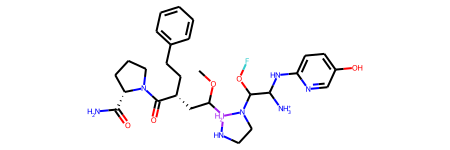

In [1596]:
Chem.MolFromSmiles(res)

In [1634]:
explain_score_dili(original_smiles)

Predictions: tensor([[0.4881]])
Loss: tensor([-0.6697])
Distance: tensor([-0.])


/home/wwydmanski/.conda/envs/drug-design/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


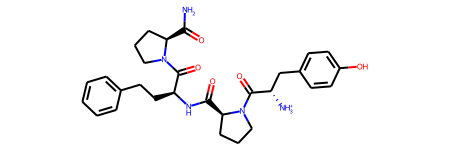

In [1586]:
Chem.MolFromSmiles(original_smiles)

### Increase antagonism

In [1385]:
smiles_list = dframe['smiles'].values
smiles_list = smiles_list[dframe['fname'].apply(lambda x: 'inactive' in x)]

In [1568]:
smiles_list[preds[:, 1].cpu().detach()<0.3][2985]

'c1cc(O)ccc1C[C@H]([NH3+])C(=O)N2CCC[C@H]2C(=O)N[C@@H](CCc3ccccc3)C(=O)N4CCC[C@H]4C(=O)N'

In [1386]:
encoded = encode(smiles_list)

In [1387]:
preds = model(torch.tensor(encoded).cuda())

In [1482]:
vals, indexes = torch.sort(preds[preds[:, 1]<0.3, 1])

In [1483]:
vals[-10:], indexes[-10:]

(tensor([0.2907, 0.2933, 0.2934, 0.2934, 0.2949, 0.2964, 0.2979, 0.2983, 0.2987,
         0.2993], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([2985, 1833, 1193, 2438,  683, 1430,  747, 1348,    0, 2859],
        device='cuda:0'))

In [1394]:
dframe

,Unnamed: 0,smiles,fname,set
0,0,c1ccccc1N(CNC2=O)C23CCN(CC3)C(=O)OCc4cccc(c4)O...,mu_human_IC50_binding_all_inactives_450_struct...,train
1,1,c1cccc(c12)n(c(=O)[nH]2)C3CCN(CC3)C(=O)OCc(c4)...,mu_human_IC50_binding_all_inactives_450_struct...,train
3,3,COc1cc(N)c(Cl)cc1C(=O)NCC[N@H+](C)C[C@H](CCCC2...,mu_human_IC50_binding_all_inactives_450_struct...,val
5,5,Oc(c1)cccc1[C@@]2(O)[C@@H](CCCC2)C[N@H+](C[C@@...,mu_human_IC50_binding_all_inactives_450_struct...,train
6,6,O[C@@H]1CC[N@@H+](C1)C[C@@H](c2ccccc2)n3cccc(c...,mu_human_IC50_binding_all_inactives_450_struct...,train
...,...,...,...,...
70782,70782,CCO[C@@]1([C@@]234)[C@H](N(C)CC3)Cc5c4c(c(O)cc...,mu_rat_Ki_all_inactives_1006_structures.sdf:209,train
70807,70807,ICCOCC[C@](COC)(C[C@H]1C(=O)OC)C(=O)[C@@H]([C@...,mu_rat_Ki_all_inactives_1006_structures.sdf:42,train
70970,70970,ICCCCC[C@](COC)(C[C@H]1C(=O)OC)C(=O)[C@@H]([C@...,mu_rat_Ki_all_inactives_1006_structures.sdf:105,train
71006,71006,CCN(CC)C(=O)c1ccc(cc1)N(c2cccc(c2)OC)[C@@H](C[...,mu_rat_Ki_all_inactives_1006_structures.sdf:97,train
